# SITCOM-989 - M1M3 Inertia Compensation Performance

We need plots and metrics to evaluate the performance of the M1M3 Inertia Compensation System as described in [SITCOM-989].    
Examples of plots are:

* Hardpoint Load Cell Forces Minima and Maxima during slews as a function of time.
* Correlate the plots above with accelerations, velocities, and positions.
* (any other ideas?)

Petr asked to analyse the data obtained when slewing the telescope around 80 deg in elevation with and without inertia forces. 
The two datasets below that he used as an example contain movement from -100 deg in azimuth to 100 deg in a single slew. 
On both cases, we are using 30% motion settings in azimuth. 

* [M1M3 TMA Inertial forces Chronograph Dashboard on 2023-08-02 22:02 - 2023-08-02 22:04 UTC]
* [M1M3 TMA Inertial forces Chronograph Dashboard on 2023-07-28 02:15 - 2023-07-28 02:17 UTC]


[SITCOM-989]: https://jira.lsstcorp.org/browse/SITCOM-989


[M1M3 TMA Inertial forces Chronograph Dashboard on 2023-08-02 22:02 - 2023-08-02 22:04 UTC]: https://summit-lsp.lsst.codes/chronograf/sources/1/dashboards/252?redirect=%2Flogin%3Fredirect%3D%252Fsources%252F1%252Fdashboards%252F252%253Frefresh%253D30s%2526tempVars%255BDownsample%255D%253DDefault%2526tempVars%255BFunction%255D%253Draw%2526lower%253Dnow%2528%2529%252520-%25252015m%2526zoomedLower%253D2023-08-02T21%25253A23%25253A19.366Z%2526zoomedUpper%253D2023-08-02T21%25253A23%25253A23.843Z&refresh=Paused&tempVars%5BDownsample%5D=Default&tempVars%5BFunction%5D=mean%28%29&lower=2023-08-02T20%3A00%3A00.000Z&upper=2023-08-03T02%3A00%3A00.000Z&zoomedLower=2023-08-02T22%3A02%3A24.799Z&zoomedUpper=2023-08-02T22%3A04%3A02.450Zhttps://summit-lsp.lsst.codes/chronograf/sources/1/dashboards/252?redirect=%2Flogin%3Fredirect%3D%252Fsources%252F1%252Fdashboards%252F252%253Frefresh%253D30s%2526tempVars%255BDownsample%255D%253DDefault%2526tempVars%255BFunction%255D%253Draw%2526lower%253Dnow%2528%2529%252520-%25252015m%2526zoomedLower%253D2023-08-02T21%25253A23%25253A19.366Z%2526zoomedUpper%253D2023-08-02T21%25253A23%25253A23.843Z&refresh=Paused&tempVars%5BDownsample%5D=Default&tempVars%5BFunction%5D=mean%28%29&lower=2023-08-02T20%3A00%3A00.000Z&upper=2023-08-03T02%3A00%3A00.000Z&zoomedLower=2023-08-02T22%3A02%3A24.799Z&zoomedUpper=2023-08-02T22%3A04%3A02.450Z


[M1M3 TMA Inertial forces Chronograph Dashboard on 2023-07-28 02:15 - 2023-07-28 02:17 UTC]:https://summit-lsp.lsst.codes/chronograf/sources/1/dashboards/252?redirect=%2Flogin%3Fredirect%3D%252Fsources%252F1%252Fdashboards%252F252%253Frefresh%253D30s%2526tempVars%255BDownsample%255D%253DDefault%2526tempVars%255BFunction%255D%253Draw%2526lower%253Dnow%2528%2529%252520-%25252015m%2526zoomedLower%253D2023-08-02T21%25253A23%25253A19.366Z%2526zoomedUpper%253D2023-08-02T21%25253A23%25253A23.843Z&refresh=Paused&tempVars%5BDownsample%5D=Default&tempVars%5BFunction%5D=mean%28%29&lower=2023-07-28T02%3A00%3A00.000Z&upper=2023-07-28T03%3A30%3A00.000Z&zoomedLower=2023-07-28T02%3A15%3A45.730Z&zoomedUpper=2023-07-28T02%3A17%3A11.966Z

## Notebook Preparation

In [29]:
# Dataset 1 - Az Slew from -100 to 100 with 80 El, 30% motion settings and Inertia Compensation On
start = "2023-08-02T22:02:30"
end = "2023-08-02T22:04:00"

In [20]:
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from astropy.time import Time, TimeDelta
from dataclasses import dataclass

from lsst.sitcom import vandv

In [5]:
efd_client = vandv.efd.create_efd_client()

In [14]:
number_of_hardpoints = 6
measured_forces_topics = [f"measuredForce{i}" for i in range(6)]

### Helper Functions

In [23]:
async def query_dataset(start, end):
    """
    Queries all the relevant data, resample them to have the same requency and merge them in a single dataframe.
    
    Parameters
    ----------
    start : str
        Start date and time in ISO format and in UTC.
    end : str 
        End date and time in ISO format and in UTC.
        
    Returns
    -------
    pd.DataFrame
    """    
    hp_measured_forces = await efd_client.select_time_series(
        "lsst.sal.MTM1M3.hardpointActuatorData", 
        measured_forces_topics, 
        Time(start, scale='utc'), 
        Time(end, scale='utc')
    )
    hp_measured_forces = hp_measured_forces.resample("1s").mean()
    
    return hp_measured_forces

## Data Collection

In [30]:
# DataFrame HardPoint Measured Forces
df_hpmf = await query_dataset(start, end)

## Plots and Analysis

In [42]:
def plot_hp_measured_data(df):
    """
    Plots the HP Measured Data as a function of the time.
    
    Parameters
    ----------
    df : pd.DataFrame
        Table containing the HP measured forces (the columns should be 
        `measuredForces0`, `measuredForces1`, etc.). The index should be 
        a timestamp. 
    """                   
    fig, ax = plt.subplots(
        num="HP Measured Forces",
        dpi=120,
        figsize=(12, 4)
    )

    for hp in range(number_of_hardpoints):
        topic = measured_forces_topics[hp]

        ax.plot(
            df[topic], 
            "-",
            label=f"HP{hp+1}",
        )

    ax.set_title(f"HP Measured Data\n {df.index[0]} - {df.index[-1]}")
    ax.set_xlabel("Time [UTC]")
    ax.set_ylabel("HP Measured Forces [N]")
    ax.grid(":", alpha=0.2)
    ax.legend(ncol=3)

    plt.show()

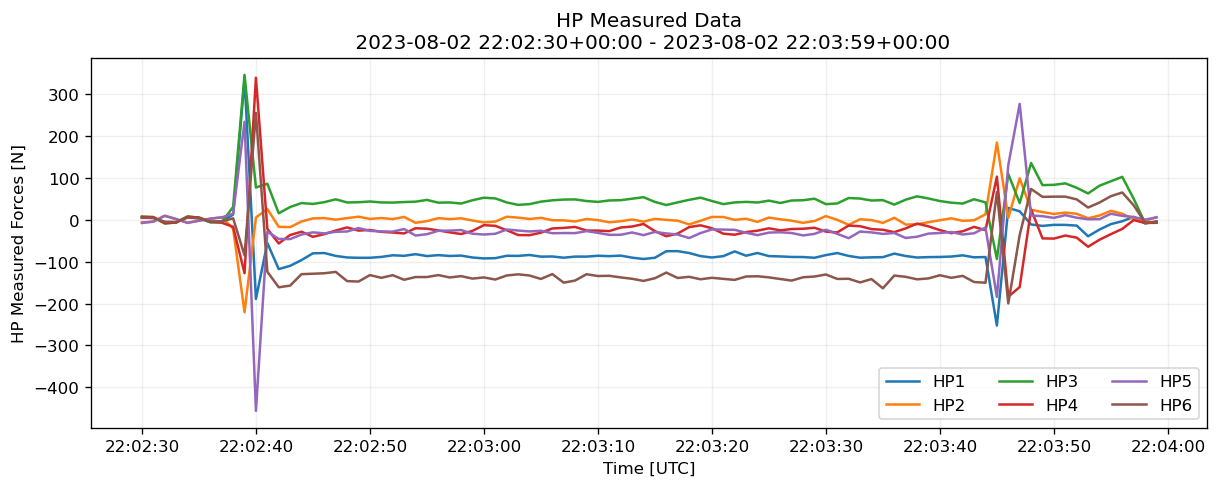

In [43]:
plot_hp_measured_data(df_hpmf)